In [42]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scipy as sp

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import matplotlib as mpl
import matplotlib.pylab as plt

import seaborn as sns

# Table of Contents
>## 1. Polynomial Regression for Non-linear Data
* 1.1. Non-linear Data
* 1.2. Linear Basis Function Models
* 1.3. Polynomial Regression
* 1.4. Polynomial Regression with `StatsModels`

>## 2. Overfitting
* 2.1. Example of Overfitting

>## 3. Cross-Validation with `Scikit-Learn`
* 3.1. Step 1. Split Data
* 3.2. Step 2. Cross-Validation Generators
* 3.3. Step 3. Cross-Validation

>## 4. Regularization
* 4.1. Ridge
* 4.2. Lasso
* 4.3. Elastic Net
* 4.4. Advantage of Regularization: weights are not sensitive to data
* 4.5. Ridge & Lasso

>## 5. Regularization with `StatsModels`
* 5.1. Model without Regularization
* 5.2. Ridge Model (`L1_wt = 0`)
* 5.3. Lasso Model (`L1_wt = 1`)
* 5.4. Elastic Net (`0 < L1_wt < 1`)

>## 6. Regularization with `Scikit-Learn`
* 6.1. Model without Regularization
* 6.2. Ridge Model
* 6.3. Lasso Model
* 6.4. Elastic Net

>## 7. Model Selection & Optimization
* 7.1. Dimension of Polynomial Regression
* 7.2. Hyperparameter of Regularized Model

# 1. Polynomial Regression for Non-linear Data

## 1.1. Non-linear Data

In [3]:
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
    X = X[:, np.newaxis]
    return (X, y)

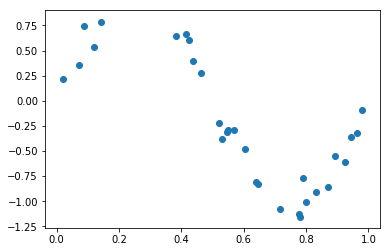

In [4]:
X, y = make_nonlinear()
plt.scatter(X, y)
plt.show()

## 1.2. Linear Basis Function Models
* Instead of using non-linear models, use basis function:
$$ y_i = \sum_{i=1}^{D} w_i x_i = w^T x \;\;\; \rightarrow \;\;\; y_i = \sum_{j=1}^{M} w_j \phi_j(x)  = w^T \phi(x)  $$

## 1.3. Polynomial Regression
$$ y = w_0 + w_1x + w_2x^2  + \ldots  + w_M x^M $$

## 1.4. Polynomial Regression with `StatsModels`
* Simply use `from_formula`

In [5]:
dfX = pd.DataFrame(X, columns=["x"])
dfX = sm.add_constant(dfX)
dfy = pd.DataFrame(y, columns=["y"])
df = pd.concat([dfX, dfy], axis=1)

#### Case 1. `"y ~ x"`

In [4]:
print(sm.OLS.from_formula("y ~ x", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     36.36
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           1.69e-06
Time:                        09:40:08   Log-Likelihood:                -15.360
No. Observations:                  30   AIC:                             34.72
Df Residuals:                      28   BIC:                             37.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7140      0.176      4.064      0.0

#### Case 2. `"y ~ x + I(x**2)"`

In [5]:
print(sm.OLS.from_formula("y ~ x + I(x**2)", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     18.38
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           9.14e-06
Time:                        09:40:09   Log-Likelihood:                -14.953
No. Observations:                  30   AIC:                             35.91
Df Residuals:                      27   BIC:                             40.11
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8638      0.248      3.487      0.0

#### Case 3. `"y ~ x + I(x**2) + I(x**3)"`

In [6]:
print(sm.OLS.from_formula("y ~ x + I(x**2) + I(x**3)", data=df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     186.7
Date:                Thu, 26 Jul 2018   Prob (F-statistic):           1.06e-17
Time:                        14:30:44   Log-Likelihood:                 18.883
No. Observations:                  30   AIC:                            -29.77
Df Residuals:                      26   BIC:                            -24.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2039      0.109     -1.876      0.0

#### Compare 3 Models

In [7]:
def polyreg(degree, seed=0, ax=None):
    X, y = make_nonlinear(seed)
    
    dfX = pd.DataFrame(X, columns=["x"])
    dfX = sm.add_constant(dfX)
    dfy = pd.DataFrame(y, columns=["y"])
    df = pd.concat([dfX, dfy], axis=1)
    
    model_str = "y ~ "
    for i in range(degree):
        if i == 0:
            prefix = ""
        else:
            prefix = " + "
        model_str += prefix + "I(x**{})".format(i + 1)
    model = sm.OLS.from_formula(model_str, data=df)
    result = model.fit()
    
    if ax:
        ax.scatter(X, y)
        xx = np.linspace(0, 1, 1000)
        dfX_new = pd.DataFrame(xx[:, np.newaxis], columns=["x"])
        ax.plot(xx, result.predict(dfX_new))
        ax.set_ylim(-2, 2)
        ax.set_title("Degree={}, Seed={}".format(degree, seed))
        xlabel = "\n".join(str(result.params).split("\n")[:-1])
        font = {'family': 'NanumGothicCoding', 'color':  'black', 'size': 10}
        ax.set_xlabel(xlabel, fontdict=font)
    
    return result

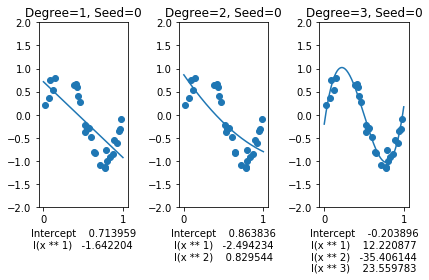

In [8]:
ax1 = plt.subplot(131)
polyreg(1, ax=ax1)
ax2 = plt.subplot(132)
polyreg(2, ax=ax2)
ax3 = plt.subplot(133)
polyreg(3, ax=ax3)
plt.tight_layout()
plt.show()

# 2. Overfitting
* Cause 1: Too many variables (compared to the data-size)
* Cause 2: Variables are not independent
* Effect 1: Huge error for unused input
* Effect 2: The weights are overly sensitive to the sample

## 2.1. Example of Overfitting

#### As the degree of model increases, overfitting occurs

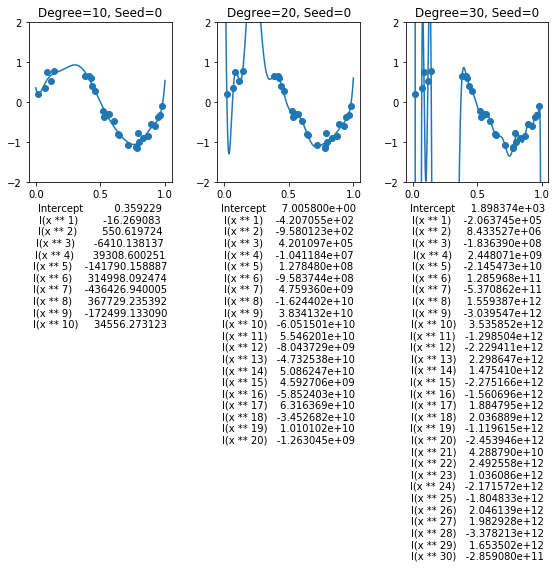

In [9]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(131)
polyreg(10, ax=ax1)
ax2 = plt.subplot(132)
polyreg(20, ax=ax2)
ax3 = plt.subplot(133)
polyreg(30, ax=ax3)
plt.tight_layout()
plt.show()

#### The model is overly sensitive to the training data

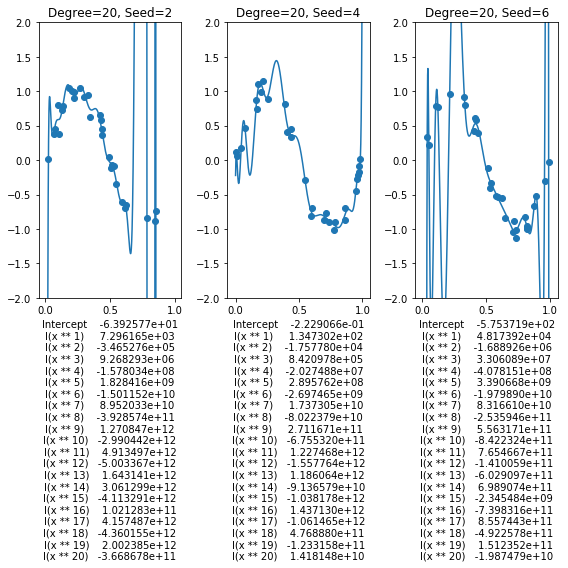

In [10]:
plt.figure(figsize=(8, 8))
ax1 = plt.subplot(131)
polyreg(20, seed=2, ax=ax1)
ax2 = plt.subplot(132)
polyreg(20, seed=4, ax=ax2)
ax3 = plt.subplot(133)
polyreg(20, seed=6, ax=ax3)
plt.tight_layout()
plt.show()

# 3. Cross-Validation with `Scikit-Learn`
* **Cross-Validation**: Data $\rightarrow$ **Training set** + **Test set** + (Validation set)

  * Train with **Training set**
  * Test with **Test set** $\rightarrow$ **mean performance** & **performance variance**

## 3.1. Step 1. Split Data
* `train_test_split()`
* **Parameters:**
  * `arrays`: data
  * `test_size` & `train_size`: only one of them is enough, provide float(0~1) or int(no. of samples)
  * `random_state`
* **Returns**
  * List of arrays
* **Example**

>```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
```

## 3.2. Step 2. Cross-Validation Generators

### K-fold CV
* Divide data into **$K$ subsets** $\rightarrow$ **Use ${K-1}$ subsets to predict $1$ subset** $\rightarrow$ **Repeat**

In [12]:
N = 5
X = np.arange(8 * N).reshape(-1, 2) * 10
y = np.hstack([np.ones(N), np.ones(N) * 2, np.ones(N) * 3, np.ones(N) * 4])
print("X:\n", X, sep="")
print("y:\n", y, sep="")

X:
[[  0  10]
 [ 20  30]
 [ 40  50]
 [ 60  70]
 [ 80  90]
 [100 110]
 [120 130]
 [140 150]
 [160 170]
 [180 190]
 [200 210]
 [220 230]
 [240 250]
 [260 270]
 [280 290]
 [300 310]
 [320 330]
 [340 350]
 [360 370]
 [380 390]]
y:
[1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 4. 4. 4. 4. 4.]


In [15]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=3, shuffle=True, random_state=0)
for train_index, test_index in cv.split(X):
    print("test index :", test_index)
    print("train index:", train_index)
    print("=" * 80 )

test index : [ 1  6  8 10 17 18 19]
train index: [ 0  2  3  4  5  7  9 11 12 13 14 15 16]
test index : [ 2  4  5  7  9 13 14]
train index: [ 0  1  3  6  8 10 11 12 15 16 17 18 19]
test index : [ 0  3 11 12 15 16]
train index: [ 1  2  4  5  6  7  8  9 10 13 14 17 18 19]


### Leave-One-Out (LOO)
* Leave one sample as test set

In [16]:
from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()

for train_index, test_index in cv.split(X):
    print("test X:", X[test_index])
    print("test y:", y[test_index])
    print("=" * 80 )

test X: [[ 0 10]]
test y: [1.]
test X: [[20 30]]
test y: [1.]
test X: [[40 50]]
test y: [1.]
test X: [[60 70]]
test y: [1.]
test X: [[80 90]]
test y: [1.]
test X: [[100 110]]
test y: [2.]
test X: [[120 130]]
test y: [2.]
test X: [[140 150]]
test y: [2.]
test X: [[160 170]]
test y: [2.]
test X: [[180 190]]
test y: [2.]
test X: [[200 210]]
test y: [3.]
test X: [[220 230]]
test y: [3.]
test X: [[240 250]]
test y: [3.]
test X: [[260 270]]
test y: [3.]
test X: [[280 290]]
test y: [3.]
test X: [[300 310]]
test y: [4.]
test X: [[320 330]]
test y: [4.]
test X: [[340 350]]
test y: [4.]
test X: [[360 370]]
test y: [4.]
test X: [[380 390]]
test y: [4.]


### ShuffleSplit
* Allow repeated selection

In [17]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=.5, random_state=0)

for train_index, test_index in cv.split(X):
    print("test X:\n", X[test_index])
    print("=" * 20 )        

test X:
 [[360 370]
 [ 20  30]
 [380 390]
 [160 170]
 [200 210]
 [340 350]
 [120 130]
 [260 270]
 [ 80  90]
 [ 40  50]]
test X:
 [[220 230]
 [ 20  30]
 [360 370]
 [340 350]
 [ 40  50]
 [240 250]
 [380 390]
 [320 330]
 [200 210]
 [  0  10]]
test X:
 [[300 310]
 [260 270]
 [240 250]
 [100 110]
 [220 230]
 [ 40  50]
 [160 170]
 [120 130]
 [ 60  70]
 [340 350]]
test X:
 [[360 370]
 [  0  10]
 [260 270]
 [ 40  50]
 [ 60  70]
 [340 350]
 [140 150]
 [240 250]
 [280 290]
 [320 330]]
test X:
 [[140 150]
 [ 20  30]
 [ 40  50]
 [380 390]
 [100 110]
 [360 370]
 [160 170]
 [340 350]
 [300 310]
 [320 330]]


## 3.3. Step 3. Cross-Validation
* `cross_val_score(estimator, X, y=None, scoring=None, cv=None)` 
* **Parameters:**
  * `estimator`: model (the ‘fit’ method should be available)
  * `X`, `y`: data
  * `scoring`: string
  * `cv`: Cross-Validator (if `None`, use `3-fold CV`, if $K$, use `K-fold CV`)
* **Returns**
  * `scores`: list of performance scores

In [18]:
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X, y, coef = make_regression(n_samples=1000, n_features=1, noise=20, coef=True, random_state=0)

model = LinearRegression()
cv = KFold(10)

scores = np.zeros(10)
for i, (train_index, test_index) in enumerate(cv.split(X)):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scores[i] = r2_score(y_test, y_pred)

scores

array([0.95636425, 0.94908323, 0.93880683, 0.92906829, 0.93119768,
       0.95362566, 0.93217768, 0.94308775, 0.94579305, 0.94749884])

In [19]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X, y, scoring="r2", cv=cv)

array([0.95636425, 0.94908323, 0.93880683, 0.92906829, 0.93119768,
       0.95362566, 0.93217768, 0.94308775, 0.94579305, 0.94749884])

# 4. Regularization
* Add constraints for weights (usually on their size, to prevent overfitting)
* a.k.a. Regularized Method, Penalized Method, Constrained Least Squares, ...

## 4.1. Ridge
* Regularization term: **squared sum of weights**
* $\lambda$: hyper-parameter / controls the strength of penalty

$$
\begin{eqnarray}
\text{cost} 
&=& \sum e_i^2 + \lambda \sum w_i^2
\end{eqnarray}
$$

## 4.2. Lasso
* Lasso: Least Absolute Shrinkage and Selection Operator
* Regularization term: sum of absolute values
* $\lambda$: hyper-parameter / controls the strength of penalty

$$
\begin{eqnarray}
\text{cost} 
&=& \sum e_i^2 + \lambda \sum | w_i |
\end{eqnarray}
$$

## 4.3. Elastic Net
* Ridge + Lasso
* $\lambda_1$, $\lambda_2$: hyperparameters

$$
\begin{eqnarray}
\text{cost} 
&=& \sum e_i^2 + \lambda_1 \sum | w_i | + \lambda_2 \sum w_i^2
\end{eqnarray}
$$

## 4.4. Advantage of Regularization: weights are not sensitive to data

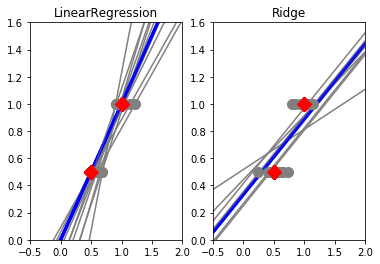

In [31]:
X_train = np.c_[.5, 1].T
y_train = [.5, 1]
X_test = np.c_[-1, 3].T
np.random.seed(0)

models = {"LinearRegression": LinearRegression(), 
          "Ridge": Ridge(alpha=0.1)}

for i, (name, model) in enumerate(models.items()):
    ax = plt.subplot(1, 2, i+1)
    for _ in range(10):
        this_X = .1 * np.random.normal(size=(2, 1)) + X_train
        model.fit(this_X, y_train)
        ax.plot(X_test, model.predict(X_test), color='.5')
        ax.scatter(this_X, y_train, s=100, c='.5', marker='o', zorder=10)
        model.fit(X_train, y_train)
        ax.plot(X_test, model.predict(X_test), linewidth=3, color='blue', alpha=0.5)
        ax.scatter(X_train, y_train, s=100, c='r', marker='D', zorder=10)
        plt.title(name)
        ax.set_xlim(-0.5, 2)
        ax.set_ylim(0, 1.6)

## 4.5. Ridge & Lasso
* Lasso: some weights converge to 0
* Ridge: weights are decreased together

<img src="https://datascienceschool.net/upfiles/10a19727037b4898984a4330c1285486.png">

In [36]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [33]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))
    
df_ridge = pd.DataFrame(data, index=alpha).T
df_ridge

,0.001,0.01,0.1,1.0,10.0
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-9.551414,-7.199457,1.307349,29.465746,19.812822
2,-239.090354,-234.552930,-207.194814,-83.154885,-0.918458
3,520.363367,520.583136,489.691080,306.351627,75.416167
4,323.828627,320.523356,301.769437,201.629434,55.025419
5,-712.328205,-380.607066,-83.466074,5.909369,19.924600
6,413.383794,150.483752,-70.828096,-29.515927,13.948686
7,65.811629,-78.591232,-188.680164,-152.040465,-47.553816
8,167.513774,130.313059,115.712703,117.311715,48.259420
9,720.944468,592.349587,443.814054,262.944995,70.144068


In [34]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))
    
df_lasso = pd.DataFrame(data, index=alpha).T
df_lasso

,0.001,0.01,0.1,1.0,10.0
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-8.998449,-1.306575,-0.000000,0.000000,0.000000
2,-238.899740,-228.822331,-155.362882,-0.000000,0.000000
3,520.261362,525.560658,517.182017,367.701852,0.000000
4,323.429484,316.175320,275.082351,6.301904,0.000000
5,-720.251734,-307.013677,-52.540269,0.000000,0.000000
6,421.405141,89.321688,-0.000000,0.000000,0.000000
7,66.734168,-105.081398,-210.159753,-0.000000,-0.000000
8,164.448873,119.597989,0.000000,0.000000,0.000000
9,725.340440,571.330871,483.914409,307.605700,0.000000


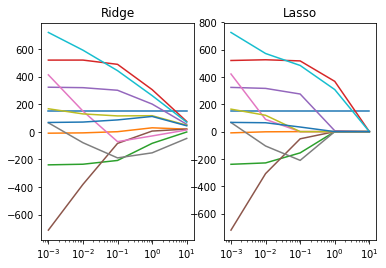

In [35]:
mpl.rcParams["font.family"] = 'DejaVu Sans'

ax1 = plt.subplot(121)
plt.semilogx(df_ridge.T)
plt.xticks(alpha)
plt.title("Ridge")
ax2 = plt.subplot(122)
plt.semilogx(df_lasso.T)
plt.xticks(alpha)
plt.title("Lasso")
plt.show()

## 5. Regularization with `StatsModels`
* Use `fit_regularized` to solve **Elastic Net** model
* Hyperparameters: $\text{alpha}$, $\text{L1_wt}$

$$
0.5 \times \text{RSS}/N + \text{alpha} \times \big( 0.5 \times (1-\text{L1_wt})\sum w_i^2 + \text{L1_wt} \sum |w_i| \big)
$$

## 5.1. Model without Regularization

In [20]:
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
    X = X[:, np.newaxis]
    return (X, y)

X, y = make_nonlinear()
dfX = pd.DataFrame(X, columns=["x"])
dfX = sm.add_constant(dfX)
dfy = pd.DataFrame(y, columns=["y"])
df = pd.concat([dfX, dfy], axis=1)

In [21]:
model = sm.OLS.from_formula("y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5) + I(x**6) + I(x**7) + I(x**8) + I(x**9)", data=df)
result1 = model.fit()
result1.params

Intercept       -0.169863
x               25.735773
I(x ** 2)     -428.141683
I(x ** 3)     3866.723115
I(x ** 4)   -18340.939664
I(x ** 5)    49326.072545
I(x ** 6)   -78884.743074
I(x ** 7)    74538.645153
I(x ** 8)   -38453.132191
I(x ** 9)     8350.254986
dtype: float64

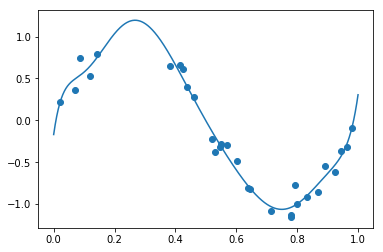

In [22]:
def plot_statsmodels(result):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    dfxx = pd.DataFrame(xx, columns=["x"])
    dfxx = sm.add_constant(dfxx)
    plt.plot(xx, result.predict(dfxx).values)
    plt.show()
    
plot_statsmodels(result1)    

## 5.2. Ridge Model (`L1_wt = 0`)

[ 0.63308745 -0.75705866 -1.07056551 -0.76835135 -0.35530367  0.0121939
  0.29917825  0.50969248  0.65793698  0.75851865]


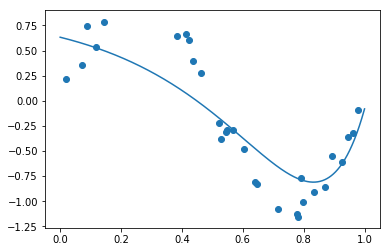

In [23]:
result2 = model.fit_regularized(alpha=0.01, L1_wt=0)
print(result2.params)
plot_statsmodels(result2) 

## 5.3. Lasso Model (`L1_wt = 1`)

Intercept    0.687949
x           -1.129134
I(x ** 2)   -1.124878
I(x ** 3)    0.000000
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.000000
I(x ** 8)    0.281484
I(x ** 9)    1.075281
dtype: float64


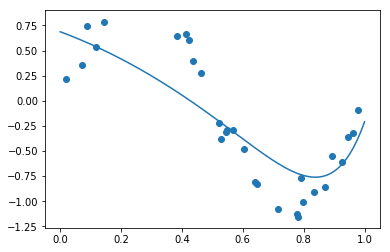

In [24]:
result3 = model.fit_regularized(alpha=0.01, L1_wt=1)
print(result3.params)
plot_statsmodels(result3) 

## 5.4. Elastic Net (`0 < L1_wt < 1`)

Intercept    0.656203
x           -0.849745
I(x ** 2)   -1.262902
I(x ** 3)   -0.425687
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.304049
I(x ** 8)    0.631908
I(x ** 9)    0.801206
dtype: float64


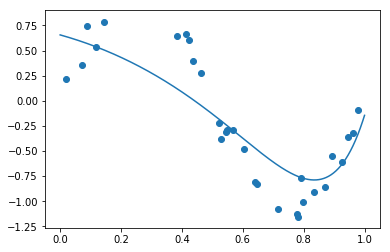

In [25]:
result4 = model.fit_regularized(alpha=0.01, L1_wt=0.5)
print(result4.params)
plot_statsmodels(result4) 

# 6. Regularization with `Scikit-Learn`
* `Ridge` class [more](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

$$ \text{RSS} + \text{alpha} \sum w_i^2 $$

* `Lasso` class [more](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

$$ 0.5 \times \text{RSS}/N + \text{alpha} \sum |w_i| $$

* `ElasticNet` class [more](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

$$ 0.5 \times \text{RSS}/N + 0.5 \times \text{alpha} \times \big(0.5 \times  (1-\text{l1_ratio})\sum w_i^2 + \text{l1_ratio} \sum |w_i| \big) $$

In [26]:
def plot_sklearn(model):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    plt.plot(xx, model.predict(xx[:, np.newaxis]))
    plt.show()

## 6.1. Model without Regularization

[ 0.00000000e+00  2.57357731e+01 -4.28141684e+02  3.86672312e+03
 -1.83409397e+04  4.93260726e+04 -7.88847431e+04  7.45386452e+04
 -3.84531322e+04  8.35025499e+03]


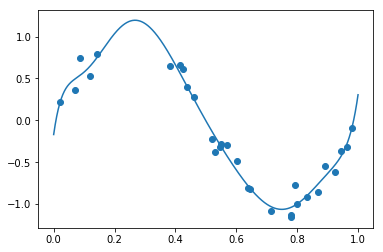

In [27]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

poly = PolynomialFeatures(9)
model = make_pipeline(poly, LinearRegression()).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

## 6.2. Ridge Model

[ 0.          1.51430399 -3.90160797 -2.6359859  -0.41526792  1.07530175
  1.64913273  1.52026782  0.94651401  0.13299614]


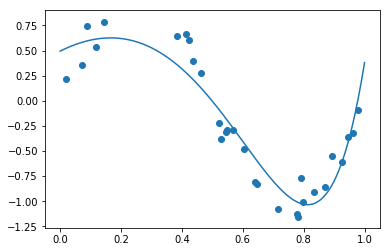

In [28]:
model = make_pipeline(poly, Ridge(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

## 6.3. Lasso Model

[ 0.         -0.07668852 -2.44096313 -0.         -0.          0.
  0.          0.          0.          1.88188725]


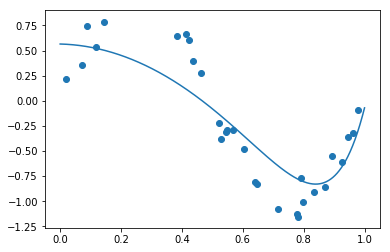

In [29]:
model = make_pipeline(poly, Lasso(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

## 6.4. Elastic Net

[ 0.         -0.83768018 -1.23944649 -0.50166684 -0.          0.
  0.          0.30382246  0.62459231  0.84262899]


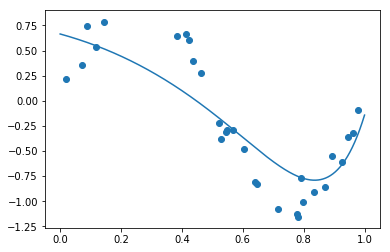

In [30]:
model = make_pipeline(poly, ElasticNet(alpha=0.01, l1_ratio=0.5)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

# 7. Model Selection & Optimization
* **How should we set the dimension of the polynomial model?**
* **How should we choose the right model & set its hyperparameters?**

## 7.1. Dimension of Polynomial Regression
* Calculate `mean` and `std` of score for various values of $D$

In [39]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score

n_samples = 1000
np.random.seed(0)
X = np.sort(np.random.rand(n_samples))
y = np.cos(1.5 * np.pi * X) + np.random.randn(n_samples) * 0.1
X = X[:, np.newaxis]
K = 100

def cv_mse(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression()
    model = Pipeline([("polynomial_features", polynomial_features),
                      ("linear_regression", linear_regression)])
    scores = -cross_val_score(model, X, y, "mean_squared_error", cv=K)
    return scores

0.013082446984850733 0.0076064944415627335


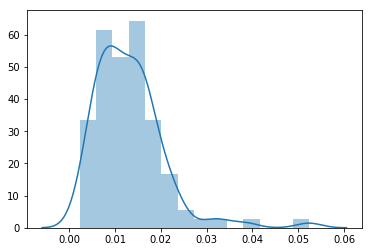

In [43]:
scores1 = cv_mse(3)
sns.distplot(scores1)
print(scores1.mean(), scores1.std())

In [44]:
D = 9
degrees = 2**np.arange(D)
all_scores = np.zeros((K, D))
for i, d in enumerate(degrees):
    scores = cv_mse(d)
    all_scores[:, i] = scores
df = pd.DataFrame(-np.log(all_scores), columns=degrees)
df.describe()

,1,2,4,8,16,32,64,128,256
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2.152711,3.431163,4.735579,4.757005,4.746503,4.677248,4.606007,4.542724,4.473842
std,1.197341,0.801431,0.470647,0.464274,0.481904,0.696307,1.260669,1.803517,2.609651
min,-0.143751,1.023711,3.757597,3.746899,3.703366,-0.221979,-6.497555,-12.519507,-20.871817
25%,1.283354,2.877161,4.449526,4.447033,4.426597,4.411029,4.410247,4.363565,4.392659
50%,1.912740,3.341536,4.659961,4.698884,4.686885,4.667391,4.676712,4.657987,4.669905
75%,2.922163,3.963974,5.023880,5.012029,5.031433,5.031279,5.035135,4.999756,5.018042
max,5.195028,5.061568,6.386555,6.284238,6.139301,6.196407,6.307032,6.376833,6.357516


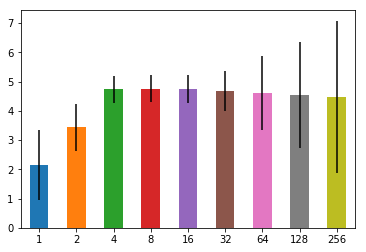

In [45]:
df.mean().plot(kind="bar", rot=0, yerr=df.std())
plt.show()

## 7.2. Hyperparameter of Regularized Model

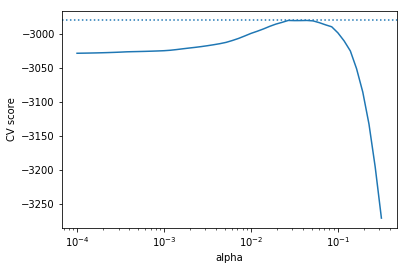

In [46]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score

data = load_diabetes()
X = data.data[:200]
y = data.target[:200]

model = Lasso()
alphas = np.logspace(-4, -.5, 50)

scores = list()

for alpha in alphas:
    model.alpha = alpha
    this_scores = cross_val_score(model, X, y, "mean_squared_error", cv=5)
    scores.append(np.mean(this_scores))

plt.semilogx(alphas, scores)
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle=':')
plt.show()

0.043939705607607904


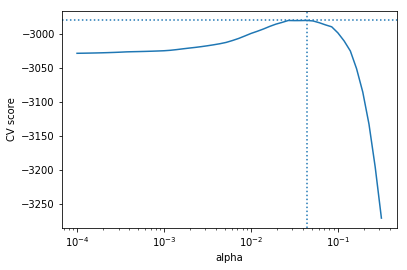

In [47]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-4, -.5, 50)
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)

print(lasso_cv.alpha_ )

scores = -lasso_cv.mse_path_.mean(axis=1)
plt.semilogx(lasso_cv.alphas_, scores)
plt.axhline(np.max(scores), linestyle=':')    
plt.axvline(lasso_cv.alpha_ , linestyle=':')   
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.show()